In [1]:
# Cell 1: install (run once in notebook environment)
# Uncomment to install if you don't have these packages in your environment.
# !pip install tensorflow opencv-python matplotlib pandas numpy

# Cell 1: imports & config
import os
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf

%matplotlib inline

# reproducibility (best-effort)
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Config
IMAGE_SIZE = (224, 224)   # MobileNetV2 default input size (you can change to 160/192 if needed)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
DATASET_DIR = "/kaggle/input/garbage-classification-v2/garbage-dataset"  # <- change this to your dataset path
OUTPUT_DIR = "./outputs"
MODEL_DIR = "./models"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


2025-09-20 06:31:15.534458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758349875.766056      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758349875.834166      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Detected classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


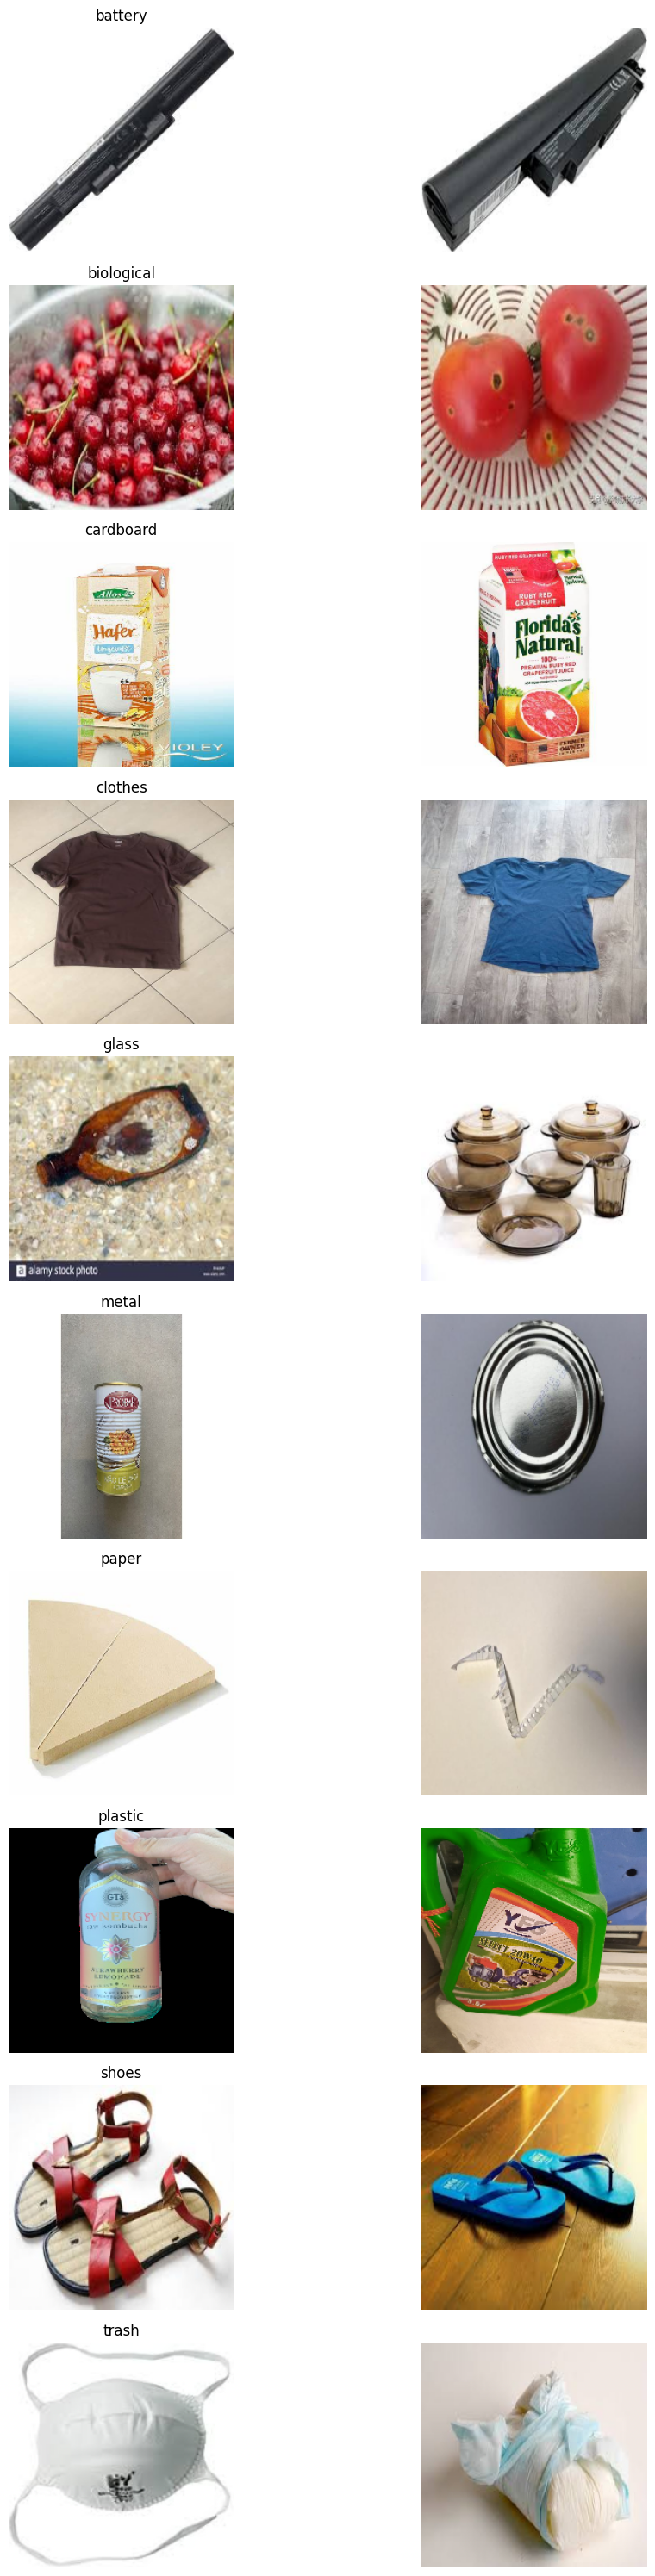

In [3]:
# Cell 2: list classes and show a few sample images per class
from IPython.display import display
dataset_path = Path(DATASET_DIR)
classes = [p.name for p in dataset_path.iterdir() if p.is_dir()]
classes = sorted(classes)
print("Detected classes:", classes)

def show_samples(dataset_dir, classes, n=3, image_size=IMAGE_SIZE):
    plt.figure(figsize=(12, 3*len(classes)))
    i = 1
    for c in classes:
        class_dir = Path(dataset_dir) / c
        imgs = list(class_dir.glob("*"))
        for j, imgpath in enumerate(imgs[:n]):
            img = cv2.imread(str(imgpath))
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            plt.subplot(len(classes), n, i)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(c)
            i += 1
    plt.tight_layout()
    
show_samples(DATASET_DIR, classes, n=2)


In [4]:
# Cell 3: ImageDataGenerator with augmentation and validation split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,   # important for consistent label order when evaluating
    seed=SEED
)

class_indices = train_gen.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}
print("class_indices:", class_indices)
print("inv_class_indices:", inv_class_indices)


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.
class_indices: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}
inv_class_indices: {0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'clothes', 4: 'glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'shoes', 9: 'trash'}


In [5]:
# Cell 4: model builder (transfer learning with MobileNetV2)
from tensorflow.keras import layers, models, optimizers

def build_model(num_classes, image_size=IMAGE_SIZE, base_trainable=False):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = base_trainable

    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.35)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

NUM_CLASSES = len(class_indices)
model = build_model(NUM_CLASSES, IMAGE_SIZE, base_trainable=False)
model.summary()


I0000 00:00:1758349958.032628      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758349958.033371      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,275,914 (8.68 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1758349976.791948     119 service.cc:148] XLA service 0x7f0fdc004690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758349976.793112     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758349976.793134     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758349977.727606     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/495 ━━━━━━━━━━━━━━━━━━━━ 1:51:30 14s/step - accuracy: 0.0625 - loss: 3.1177

I0000 00:00:1758349982.494816     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.1298 - loss: 2.5363
Epoch 1: val_accuracy improved from -inf to 0.27019, saving model to ./models/best_model.h5
495/495 ━━━━━━━━━━━━━━━━━━━━ 412s 806ms/step - accuracy: 0.1299 - loss: 2.5361 - val_accuracy: 0.2702 - val_loss: 2.0666 - learning_rate: 1.0000e-04
Epoch 2/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2225 - loss: 2.2799
Epoch 2: val_accuracy improved from 0.27019 to 0.29906, saving model to ./models/best_model.h5
495/495 ━━━━━━━━━━━━━━━━━━━━ 248s 501ms/step - accuracy: 0.2225 - loss: 2.2799 - val_accuracy: 0.2991 - val_loss: 1.9846 - learning_rate: 1.0000e-04
Epoch 3/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.2433 - loss: 2.2014
Epoch 3: val_accuracy improved from 0.29906 to 0.32160, saving model to ./models/best_model.h5
495/495 ━━━━━━━━━━━━━━━━━━━━ 245s 495ms/step - accuracy: 0.2433 - loss: 2.2014 - val_accuracy: 0.3216 - val_loss: 1.9491 - learning_rate: 1.0000e-04
Epoch 4/20
495/495

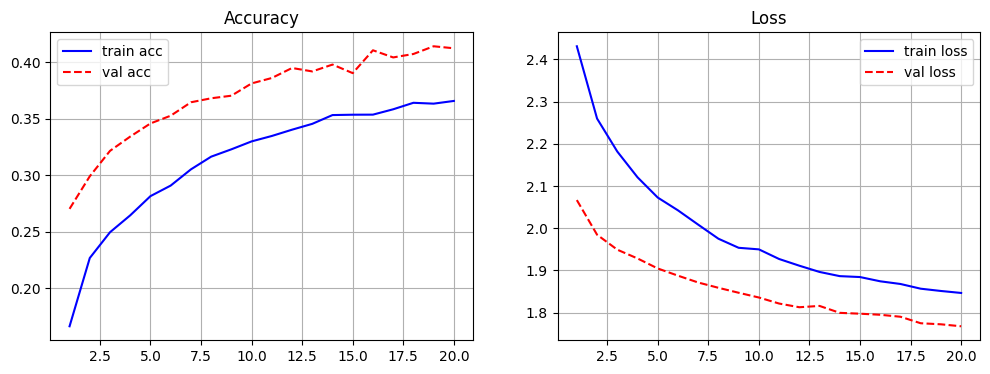

In [6]:
# Cell 5: training with callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = os.path.join(MODEL_DIR, "best_model.h5")
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

EPOCHS = 20  # change if you want more epochs

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)

# Save final model
model.save(os.path.join(MODEL_DIR, "final_model.h5"))

# Plot history
def plot_history(history, out_prefix=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='train acc')
    plt.plot(epochs, val_acc, 'r--', label='val acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='train loss')
    plt.plot(epochs, val_loss, 'r--', label='val loss')
    plt.title('Loss')
    plt.legend()
    plt.grid()

    plt.show()

plot_history(history)


In [8]:
import os

SAVE_DIR = "/kaggle/working/models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save in new Keras format
model.save(os.path.join(SAVE_DIR, "waste_classifier.keras"))

# Optionally also save in HDF5 format (for older tools)
model.save(os.path.join(SAVE_DIR, "waste_classifier.h5"))

print("✅ Models saved to:", SAVE_DIR)


✅ Models saved to: /kaggle/working/models


⚠️ Using in-memory model (not loaded from disk)
124/124 ━━━━━━━━━━━━━━━━━━━━ 58s 437ms/step


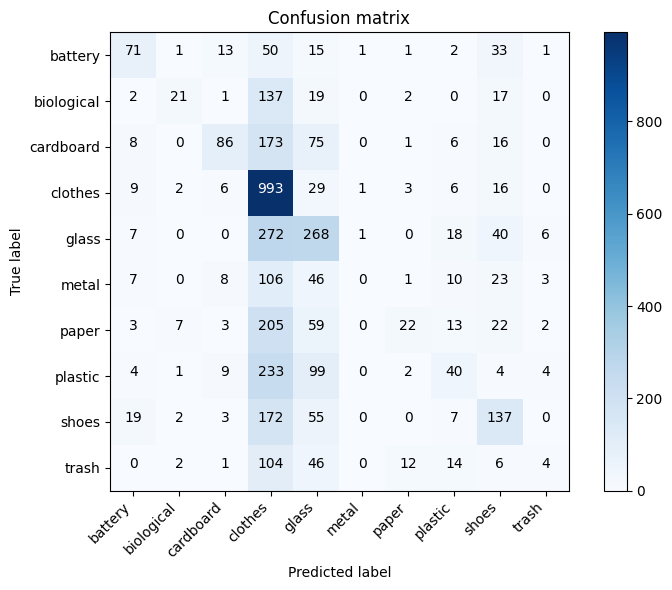

✅ Overall (validation) accuracy: 0.41580146872625984


In [10]:
# ✅ Evaluation cell (Keras 3 safe)

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Path to your saved model
MODEL_DIR = "/kaggle/working/models/waste_classifier.keras"
best_model_path = os.path.join(MODEL_DIR, "waste_classifier.keras")

# Load the saved model
if os.path.exists(best_model_path):
    eval_model = tf.keras.models.load_model(best_model_path)
    print("✅ Loaded model from:", best_model_path)
else:
    eval_model = model   # fallback if model is not saved yet
    print("⚠️ Using in-memory model (not loaded from disk)")

# Make predictions on validation data
steps = int(np.ceil(val_gen.samples / val_gen.batch_size))
preds = eval_model.predict(val_gen, steps=steps, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes[:len(y_pred)]

# Confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(inv_class_indices)).numpy()

# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(inv_class_indices))
plt.xticks(tick_marks, [inv_class_indices[i] for i in range(len(inv_class_indices))], rotation=45, ha='right')
plt.yticks(tick_marks, [inv_class_indices[i] for i in range(len(inv_class_indices))])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate numbers
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# Overall accuracy
overall_accuracy = float(np.trace(cm) / cm.sum())
print("✅ Overall (validation) accuracy:", overall_accuracy)


In [11]:
# Cell 9: predict single image (shows image inline with matplotlib)
def predict_image(image_path, model_path=None, top_k=1):
    if model_path is None:
        model_to_use = eval_model
    else:
        model_to_use = tf.keras.models.load_model(model_path)

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
    inp = img_resized.astype(np.float32) / 255.0
    inp = np.expand_dims(inp, axis=0)

    preds = model_to_use.predict(inp)[0]
    top_idx = preds.argsort()[-top_k:][::-1]
    results = [(inv_class_indices[i], float(preds[i])) for i in top_idx]

    # display
    plt.figure(figsize=(6,4))
    plt.imshow(img_resized)
    label_text = ", ".join([f"{name} ({prob*100:.1f}%)" for name, prob in results])
    plt.title(label_text)
    plt.axis('off')
    plt.show()
    return results

# Example usage:
# replace sample_image.jpg with a real image path
# results = predict_image("path/to/sample_image.jpg", model_path=os.path.join(MODEL_DIR,"best_model.h5"))
# print(results)


In [12]:
# Example usage:
# replace sample_image.jpg with a real image path
 results = predict_image("/kaggle/input/garbage-classification-v2/garbage-dataset/battery/battery_1.jpg", model_path=os.path.join(MODEL_DIR,"/kaggle/working/models/waste_classifier.keras"))
print(results)

IndentationError: unexpected indent (4157135193.py, line 3)

✅ Model loaded from: ./models/waste_classifier.keras


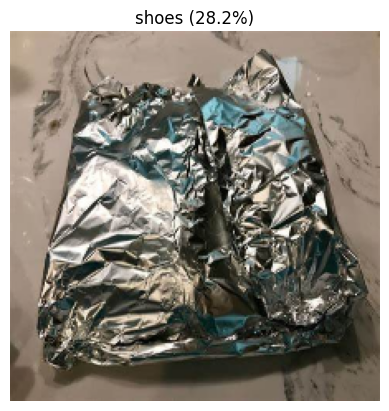

Predicted: shoes with 0.28 confidence


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Path to saved model
MODEL_DIR = "./models"
model_path = os.path.join(MODEL_DIR, "waste_classifier.keras")

# Load model
predict_model = tf.keras.models.load_model(model_path)
print("✅ Model loaded from:", model_path)

# Function for prediction
def predict_single_image(image_path, model, class_map, image_size=(224,224)):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
        
    # Preprocess (resize + normalize)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, image_size)
    inp = img_resized.astype(np.float32) / 255.0
    inp = np.expand_dims(inp, axis=0)  # shape (1, h, w, 3)

    # Predict
    preds = model.predict(inp, verbose=0)[0]
    top_idx = np.argmax(preds)
    class_name = class_map[top_idx]
    confidence = float(preds[top_idx])

    # Show result
    plt.imshow(img_resized)
    plt.title(f"{class_name} ({confidence*100:.1f}%)")
    plt.axis("off")
    plt.show()

    return class_name, confidence

# Example usage:
# Replace with a real image path (from your dataset or test folder)
test_image = "/kaggle/input/garbage-classification-v2/garbage-dataset/metal/metal_1001.jpg"   # change this path!
pred_class, pred_conf = predict_single_image(test_image, predict_model, inv_class_indices)
print(f"Predicted: {pred_class} with {pred_conf:.2f} confidence")


In [22]:
for cls, idx in class_indices.items():
    print(f"{cls}: {np.sum(train_gen.classes == idx)} images")


battery: 756 images
biological: 798 images
cardboard: 1460 images
clothes: 4262 images
glass: 2449 images
metal: 816 images
paper: 1344 images
plastic: 1588 images
shoes: 1582 images
trash: 758 images
